In [85]:
#Ensure we are using the right kernel
spark.version

'3.1.3'

In [86]:
import time
import pandas as pd
from itertools import islice
import matplotlib.pyplot as plt

In [3]:
from pyspark.sql import functions as f
from pyspark.sql import types as t

In [4]:
from google.cloud import storage

In [5]:
# List all files in given COS directory
def list_blobs(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        print(blob.name + '\t' + str(blob.size))

In [6]:
# List all files in given COS directory
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    blob_name = []
    blob_size = []
    
    for blob in blobs:
        blob_name.append(blob.name)
        blob_size.append(blob.size)

    blobs_df = pd.DataFrame(list(zip(blob_name, blob_size)), columns=['Name','Size'])

    blobs_df = blobs_df.style.format({"Size": "{:,.0f}"}) 
    
    return blobs_df

In [7]:
# Delete folder from COS bucket
def delete_folder(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        blob.delete()

In [8]:
# Reading data from open bucket, avaible to all students
bucket_read = 'msca-bdp-data-open'

# Saving results into individual bucket, students must update to their own bucket `msca-bdp-students-bucket` and use `CNET ID` as a folder prefix
bucket_write = 'msca-bdp-data-shared'

## Loading in the file and understanding the schema of each file

In [ ]:
!hadoop fs -ls "gs://msca-bdp-data-open/final_project_git"

In [ ]:
#list_blobs(bucket_read, 'final_project_git/')
#list_blobs_pd(bucket_read, 'final_project_git/')

spark.read.parquet('gs://msca-bdp-data-open/final_project_git/commits').printSchema()

In [ ]:
spark.read.parquet('gs://msca-bdp-data-open/final_project_git/contents').printSchema()

In [ ]:
spark.read.parquet('gs://msca-bdp-data-open/final_project_git/files').printSchema()

In [ ]:
spark.read.parquet('gs://msca-bdp-data-open/final_project_git/languages').printSchema()

In [ ]:
spark.read.parquet('gs://msca-bdp-data-open/final_project_git/licenses').printSchema()

In [ ]:
spark.read.parquet('gs://msca-bdp-data-open/final_project_git/commits').first()

This is the only file with dates. The dates are in epochs -> need to convert this
    Ex.) 1647357073 is Tuesday, March 15, 2022 3:11:13 PM

In [ ]:
spark.read.parquet('gs://msca-bdp-data-open/final_project_git/contents').first()

In [ ]:
spark.read.parquet('gs://msca-bdp-data-open/final_project_git/files').first()

In [ ]:
spark.read.parquet('gs://msca-bdp-data-open/final_project_git/languages').first()

In [ ]:
spark.read.parquet('gs://msca-bdp-data-open/final_project_git/licenses').first()

## EDA

In [9]:
from pyspark.sql.functions import *

In [15]:
commits_df = spark.read.parquet('gs://msca-bdp-data-open/final_project_git/commits')

In [ ]:
#commits_na_df = commits_df.select([round((count(when(isnan(c) | col(c).isNull(), c))/count(lit(1))), 6).alias(c) for c in commits_df.columns])  
#commits_na_df.show()

In [ ]:
license_df = spark.read.parquet('gs://msca-bdp-data-open/final_project_git/licenses')

license_na_df = license_df.select([round((count(when(isnan(c) | col(c).isNull(), c))/count(lit(1))), 6).alias(c) for c in license_df.columns])
#Checking the
license_na_df.show()

In [ ]:
commits_df.distinct().count()

In [ ]:
commits_df = commits_df.distinct()

## Data Cleaning

In [11]:
cleaned_commits_df = commits_df.select\
([col('commit'),col('author.time_sec').alias('author_time_sec'), col('repo_name'), col('message'), col('subject')])
cleaned_commits_df = cleaned_commits_df.withColumn("time_timestamp", (f.col("author_time_sec")).cast("timestamp"))
cleaned_commits_df = cleaned_commits_df.withColumn('date_only', to_date(col('time_timestamp')))
cleaned_commits_df = cleaned_commits_df.withColumn('year', year(col('date_only')))
cleaned_commits_df = cleaned_commits_df.filter('year > 2007').filter('year < 2023')


cleaned_commits_df = cleaned_commits_df.filter('author_time_sec != 1495574320').filter('author_time_sec != 1508791747').filter('author_time_sec != 1474329600').filter('author_time_sec != 1425427200')


In [12]:
cleaned_commits_df.printSchema()

root
 |-- commit: string (nullable = true)
 |-- author_time_sec: long (nullable = true)
 |-- repo_name: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- message: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- time_timestamp: timestamp (nullable = true)
 |-- date_only: date (nullable = true)
 |-- year: integer (nullable = true)



## Question 1:

In [ ]:
#Has all the dates
dates_in_seconds_df = commits_df.select\
([col('author.time_sec').alias('author_time_sec'),col('committer.time_sec').alias('committer_time_sec'),col('author.date.seconds').alias('a_date_seconds'),col('committer.date.seconds').alias('c_date_seconds')])

#dates_in_seconds_df.show(5)

In [ ]:
date_na_df = dates_in_seconds_df.select([round((count(when(isnan(c) | col(c).isNull(), c))/count(lit(1))), 6).alias(c) for c in dates_in_seconds_df.columns])
#date_na_df.show()

In [ ]:
#Other three columns NOT NEEDED
author_time_sec = dates_in_seconds_df.select([col('author_time_sec')]).filter('author_time_sec != 1495574320').filter('author_time_sec != 1508791747').filter('author_time_sec != 1474329600').filter('author_time_sec != 1425427200')


In [ ]:
author_time_sec = dates_in_seconds_df.withColumn("time_timestamp", (f.col("author_time_sec")).cast("timestamp"))

In [ ]:
#author_time_sec.show(5)

In [ ]:
author_time_sec.printSchema()

In [ ]:
author_time_sec = author_time_sec.withColumn('date_only', to_date(col('time_timestamp')))

In [ ]:
author_time_sec_df = author_time_sec.groupby('date_only').agg(count("*")).orderBy('count(1)', ascending = False).toPandas()

In [ ]:
author_time_sec_df.head()

In [ ]:
author_time_sec_df['date_only']=pd.to_datetime(author_time_sec_df['date_only'])

In [ ]:
import seaborn as sns

sns.lineplot(data =author_time_sec_df,x = 'date_only', y= 'count(1)')

## Filtered Dataset

In [ ]:
author_time_sec_df['date_only'].min()

In [ ]:
author_time_sec_df['date_only'].max()

2245??? That is 222 years in the future!

In [ ]:
#Filtering the dates that are past github's time and also those dates that are in the future...
filtered_date_df = author_time_sec_df[(author_time_sec_df['date_only'] < '2023-11-23') & (author_time_sec_df['date_only'] > '2008-01-01')]

In [ ]:
import seaborn as sns

sns.lineplot(data =author_time_sec_df,x = 'date_only', y= 'count(1)')

# I don't really know if there are any data collection gaps...
# Will need to check to see if the events that happen in the later half of 2017 is real or not

In [ ]:
author_time_sec_df.iloc[author_time_sec_df['count(1)'].idxmax()]

So... On May 23rd 2017, there seemed to have been a record number of committs... lets investigate this

In [ ]:
author_time_sec.filter(author_time_sec.author_time_sec == "1474243200").show()

In [ ]:
real_events_df = commits_df.filter("author.time_sec > 1474243200").filter( "author.time_sec < 1474329599").select([col('author.time_sec'),col('message'), col('subject')])

In [ ]:
real_events_df2 = commits_df.filter( "author.time_sec ==  1508716800").select([col('author.time_sec'),col('message'), col('subject')])
real_events_df2.show(5)


These are not real events

In [ ]:
real_events_df.show(5)

In [ ]:
checking_df = real_events_df.groupby(col('time_sec')).agg(count("*")).toPandas()

In [ ]:
checking_df.sort_values(by=['count(1)'])

In [ ]:
checking_df['count(1)'].max()

## Question 2

In [ ]:
language_df = spark.read.parquet('gs://msca-bdp-data-open/final_project_git/languages')
language_df = language_df.select\
([col('repo_name'),explode(col('language.name')).alias('language_name')])


In [ ]:
language_df.groupby('language_name').agg(f.count("language_name").alias('l_count')).orderBy('l_count', ascending = False).show(5)

1. JS
2. CSS
3. HTML
4. Shell
5. Python

In [ ]:
cleaned_commits_df.show(5)

In [ ]:
temp_df = cleaned_commits_df.select\
([col('year'),explode(col('repo_name')).alias('repo_name'),col('commit')])

In [ ]:
joined_df = language_df.join(temp_df,language_df.repo_name ==  temp_df.repo_name,"inner")

joined_df2 = joined_df.select\
([col('year'),col('language_name'),col('commit')])


joined_df2 = joined_df2.sample(fraction = 0.0001, seed = 123) #Roughly 40k rows

In [ ]:
joined_df2_2008 = joined_df2.filter('year = 2008 or year = 2009 or year = 2010 or year = 2011')
joined_df2_2012 = joined_df2.filter('year = 2012 or year = 2013 or year = 2014 or year = 2015')
joined_df2_2016 = joined_df2.filter('year = 2016 or year = 2017 or year = 2018 or year = 2019')
joined_df2_2020 = joined_df2.filter('year = 20020 or year = 2021 or year = 2022 or year = 2023')

## CountDistinct

In [ ]:
joined_df2_2008.groupby('language_name').agg(countDistinct('commit')).orderBy('count(commit)', ascending = False).show(5)
joined_df2_2012.groupby('language_name').agg(countDistinct('commit')).orderBy('count(commit)', ascending = False).show(5)
joined_df2_2016.groupby('language_name').agg(countDistinct('commit')).orderBy('count(commit)', ascending = False).show(5)
joined_df2_2020.groupby('language_name').agg(countDistinct('commit')).orderBy('count(commit)', ascending = False).show(5)

## Question 3

In [ ]:
license_df = spark.read.parquet('gs://msca-bdp-data-open/final_project_git/licenses')

In [ ]:
license_pd_df = license_df.groupby('license').agg(count("*")).toPandas().sort_values(by =['count(1)'], ascending = False)

In [ ]:
language_df = spark.read.parquet('gs://msca-bdp-data-open/final_project_git/languages')
popular_languages_df = language_df.select\
([col('repo_name'),explode(col('language.name')).alias('language_name')])

In [ ]:
import seaborn as sns
ax = sns.barplot(data =license_pd_df,x = 'license', y= 'count(1)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()



In [ ]:
language_x_license_df = popular_languages_df.join(license_df,popular_languages_df.repo_name ==  license_df.repo_name,"inner")

# bucket_write = 'msca-bdp-students-bucket'
# language_x_license_df.write.format("parquet").\
# mode('overwrite').\
# save('gs://' + bucket_write + '/shared_data/ID/folder’)

In [ ]:
l_x_l_df = language_x_license_df.select([col('language_name'), col('license')])

In [ ]:
l_x_l_df.filter(l_x_l_df.license.contains('mit')).groupby('language_name','license').agg(count('*')).orderBy('count(1)', ascending = False).show(5)
l_x_l_df.filter(l_x_l_df.license.contains('unlicense')).groupby('language_name','license').agg(count('*')).orderBy('count(1)', ascending = False).show(5)
l_x_l_df.filter(l_x_l_df.license.contains('lgpl-3.0')).groupby('language_name','license').agg(count('*')).orderBy('count(1)', ascending = False).show(5)

In [ ]:
l_x_l_df.filter(l_x_l_df.license.contains('cc0-1.0')).groupby('language_name','license').agg(count('*')).orderBy('count(1)', ascending = False).show(5)
l_x_l_df.filter(l_x_l_df.license.contains('gpl-2.0')).groupby('language_name','license').agg(count('*')).orderBy('count(1)', ascending = False).show(5)
l_x_l_df.filter(l_x_l_df.license.contains('bsd-3-clause')).groupby('language_name','license').agg(count('*')).orderBy('count(1)', ascending = False).show(5)

In [ ]:
l_x_l_df.filter(l_x_l_df.license.contains('epl-1.0')).groupby('language_name','license').agg(count('*')).orderBy('count(1)', ascending = False).show(5)
l_x_l_df.filter(l_x_l_df.license.contains('gpl-3.0')).groupby('language_name','license').agg(count('*')).orderBy('count(1)', ascending = False).show(5)
l_x_l_df.filter(l_x_l_df.license.contains('bsd-2-clause')).groupby('language_name','license').agg(count('*')).orderBy('count(1)', ascending = False).show(5)

In [ ]:
l_x_l_df.filter(l_x_l_df.license.contains('apache-2.0')).groupby('language_name','license').agg(count('*')).orderBy('count(1)', ascending = False).show(5)
l_x_l_df.filter(l_x_l_df.license.contains('mpl-2.0')).groupby('language_name','license').agg(count('*')).orderBy('count(1)', ascending = False).show(5)
l_x_l_df.filter(l_x_l_df.license.contains('isc')).groupby('language_name','license').agg(count('*')).orderBy('count(1)', ascending = False).show(5)

In [ ]:
l_x_l_df.filter(l_x_l_df.license.contains('artistic-2.0')).groupby('language_name','license').agg(count('*')).orderBy('count(1)', ascending = False).show(5)
l_x_l_df.filter(l_x_l_df.license.contains('agpl-3.0')).groupby('language_name','license').agg(count('*')).orderBy('count(1)', ascending = False).show(5)
l_x_l_df.filter(l_x_l_df.license.contains('lgpl-2.1')).groupby('language_name','license').agg(count('*')).orderBy('count(1)', ascending = False).show(5)

## Preliminary Results:
- Javascript is more likely to be associated with mIt, isc licenses 
- Clojure is more likely to be associated with epl-1.0
- Java is more liley to be associated with apache-2.0
- Shell is more likely to be associate with gpl-2.0

## Question 4

In [23]:
popular_repo = cleaned_commits_df.select\
([col('repo_name')])

In [24]:
popular_repo.groupby('repo_name').agg(count('*')).orderBy('count(1)', ascending = False).show(5, False)

+------------------------------------+--------+
|repo_name                           |count(1)|
+------------------------------------+--------+
|[shenzhouzd/update]                 |1188563 |
|[chromium/chromium, scheib/chromium]|396640  |
|[curtclifton/curtclifton.github.io] |384809  |
|[cloudfoundry/relint-ci-pools]      |339252  |
|[duaneking/rockstar_test]           |318819  |
+------------------------------------+--------+
only showing top 5 rows



In [25]:
#group by year and rep, agg by count

In [26]:
popular_repo = cleaned_commits_df.select\
([col('author_time_sec'),col('repo_name'), col('message')])


In [27]:
popular_repo = cleaned_commits_df.select\
([col("author_time_sec"),explode(col('repo_name')).alias('repo_name2'), col('message')]).filter("repo_name2  NOT in ('shenzhouzd/update')")

In [28]:
popular_repo = popular_repo.withColumn("time_timestamp", (f.col("author_time_sec")).cast("timestamp"))
popular_repo = popular_repo.withColumn('date_only', to_date(col('time_timestamp')))

In [29]:
popular_repo = popular_repo.withColumn('year', year(col('date_only')))
popular_repo = popular_repo.filter('year > 2007').filter('year < 2023')

In [30]:
#pop_repo_df_filtered_shen = popular_repo.filter("repo_name2 in ('cminyard/linux-live-app-coredump')")#.filter('year = 2021')
#pop_repo_df_filtered_shen.show(20)

In [31]:
## Identifying which repos are popular

In [89]:
popular_repo.filter('year > 2018').groupby('repo_name2').agg(count('*')).orderBy('count(1)', ascending = False).show(30, False)

+--------------------------------+--------+
|repo_name2                      |count(1)|
+--------------------------------+--------+
|chromium/chromium               |456581  |
|scheib/chromium                 |364257  |
|cloudfoundry/relint-ci-pools    |276679  |
|cminyard/linux-live-app-coredump|272580  |
|NixOS/nixpkgs                   |263416  |
|frustreated/linux               |261169  |
|fabiocannizzo/linux             |258036  |
|mpe/powerpc                     |243515  |
|rperier/linux                   |240316  |
|tprrt/linux-stable              |231291  |
|HinTak/linux                    |201553  |
|Naoya-Horiguchi/linux           |200472  |
|rperier/linux-rockchip          |200160  |
|Homebrew/homebrew-core          |197589  |
|filcab/homebrew-core            |197272  |
|conda-forge/feedstocks          |196140  |
|lemzwerg/homebrew-core          |196135  |
|chrisfinazzo/homebrew-core      |195784  |
|makigumo/homebrew-core          |193897  |
|stgraber/homebrew-core         

In [33]:
## Looking at which languages these companies use

In [38]:
pop_repo_df_filtered = popular_repo.filter("repo_name2 in ('chromium/chromium','shenzhouzd/update', 'scheib/chromium', 'cminyard/linux-live-app-coredump', 'frustreated/linux', 'fabiocannizzo/linux', 'mpe/powerpc', 'rperier/linux', 'tprrt/linux-stable', 'HinTak/linux')")

pop_repo_pd = pop_repo_df_filtered.groupby('year','repo_name2').agg(count('*')).toPandas()



In [39]:
pop_repo_pd['pct_change'] = pop_repo_pd.groupby('repo_name2')['count(1)'].pct_change().mul(100).fillna(0).round(2)


pop_repo_pd.sort_values(['repo_name2', 'year'], inplace=True)
pop_repo_pd['PercentageChange'] = pop_repo_pd.groupby('repo_name2')['count(1)'].pct_change() * 100
pop_repo_pd.dropna(subset=['PercentageChange'], inplace=True)

pop_repo_pd.sort_values(['PercentageChange'], ascending = False).head(10)


,year,repo_name2,count(1),pct_change,PercentageChange
14,2009,scheib/chromium,35111,-68.64,145.806497
126,2009,chromium/chromium,35111,-55.10,145.806497
80,2011,scheib/chromium,62811,-32.56,34.125561
64,2011,chromium/chromium,62811,-18.10,34.125561
101,2010,scheib/chromium,46830,62.68,33.377004
19,2010,chromium/chromium,46830,-56.88,33.377004
44,2012,chromium/chromium,79963,-30.42,27.307319
71,2012,scheib/chromium,79963,12.22,27.307319
130,2019,scheib/chromium,108605,47.10,16.611549
13,2019,chromium/chromium,108605,0.00,16.611549


<AxesSubplot:xlabel='year', ylabel='count(1)'>

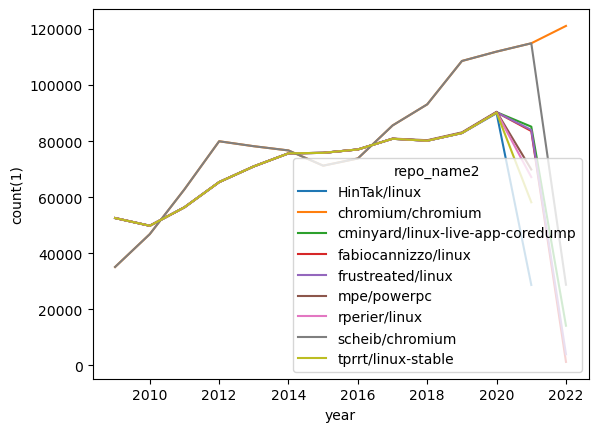

In [40]:
pop_repo_pd.head(5)

import seaborn as sns

sns.lineplot(data =pop_repo_pd,x = 'year', y= 'count(1)', hue = 'repo_name2')

In [41]:
# df_popular = popular_repo.groupby('repo_name2').agg(count('*')).orderBy('count(1)', ascending = False).limit(30)

# df_popular = df_popular.select\
# ([col('repo_name2')])

pop_repo_df_filtered = popular_repo.filter("repo_name2 in ('chromium/chromium', 'scheib/chromium', 'cminyard/linux-live-app-coredump', 'frustreated/linux', 'fabiocannizzo/linux', 'mpe/powerpc', 'rperier/linux', 'tprrt/linux-stable', 'HinTak/linux')")

language_df = spark.read.parquet('gs://msca-bdp-data-open/final_project_git/languages')
popular_languages_df = language_df.select\
([col('repo_name'),col('language.name').alias('language_name')])



In [42]:
language_of_pop_repo_df = pop_repo_df_filtered.join(popular_languages_df,pop_repo_df_filtered.repo_name2 ==  popular_languages_df.repo_name,"inner")

In [43]:
language_of_pop_repo_df.show(10)

+---------------+-------------+--------------------+-------------------+----------+----+-------------+--------------------+
|author_time_sec|   repo_name2|             message|     time_timestamp| date_only|year|    repo_name|       language_name|
+---------------+-------------+--------------------+-------------------+----------+----+-------------+--------------------+
|     1597326285|rperier/linux|drm/amd/display: ...|2020-08-13 13:44:45|2020-08-13|2020|rperier/linux|[Assembly, Awk, C...|
|     1532353605|rperier/linux|dm thin: update s...|2018-07-23 13:46:45|2018-07-23|2018|rperier/linux|[Assembly, Awk, C...|
|     1558712698|rperier/linux|IB/hfi1: Remove e...|2019-05-24 15:44:58|2019-05-24|2019|rperier/linux|[Assembly, Awk, C...|
|     1504178241|rperier/linux|media: fe_propert...|2017-08-31 11:17:21|2017-08-31|2017|rperier/linux|[Assembly, Awk, C...|
|     1534412813|rperier/linux|media: ov5640: fi...|2018-08-16 09:46:53|2018-08-16|2018|rperier/linux|[Assembly, Awk, C...|
|     13

In [44]:
language_of_pop_repo_df.groupby('repo_name','language_name').agg(count('*')).orderBy('count(1)', ascending = False).show(50, False)

+--------------------------------+-----------------------------------------------------------------------------------------------------------------------------+--------+
|repo_name                       |language_name                                                                                                                |count(1)|
+--------------------------------+-----------------------------------------------------------------------------------------------------------------------------+--------+
|chromium/chromium               |[]                                                                                                                           |1174278 |
|scheib/chromium                 |[]                                                                                                                           |1081954 |
|cminyard/linux-live-app-coredump|[Assembly, Awk, C, C++, GDB, Lex, Makefile, Objective-C, Perl, Python, Shell, SourcePawn, UnrealScript, Yacc]       

In [45]:
## Chromium does not use any programming languages... And the rest of the linux use [Assembly, Awk, C, C++, GDB, Lex, Makefile, Objective-C, Perl, Python, Shell, SourcePawn, UnrealScript, Yacc]

In [80]:
##Rapidly Growing Repo
rapid_repo = popular_repo.filter('year == 2022 or year == 2023 or year == 2021').groupby('year','repo_name2').agg(count('*')).orderBy('count(1)')

In [81]:
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import col, lag, when
window_spec = Window.partitionBy("repo_name2").orderBy("year")

In [82]:
# Calculate percentage change using lag
df_percentage_change = rapid_repo.withColumn("prev_value", lag("count(1)").over(window_spec))
df_percentage_change = df_percentage_change.withColumn("percentage_change",when(col("prev_value").isNotNull(), (col("count(1)") - col("prev_value")) / col("prev_value")).otherwise(0)).drop("prev_value")

In [83]:
pc_df = df_percentage_change.orderBy('percentage_change', ascending = False)
pc_df = df_percentage_change.withColumn("result_column", col("count(1)") - col("percentage_change")).filter(col('result_column') > 1)


In [87]:
pc_df.orderBy('percentage_change', ascending = False).filter(col('count(1)') > 1000).show(10, False)

+----+----------------------------------+--------+------------------+------------------+
|year|repo_name2                        |count(1)|percentage_change |result_column     |
+----+----------------------------------+--------+------------------+------------------+
|2022|payday-restoration/restoration-mod|3125    |47.07692307692308 |3077.923076923077 |
|2022|code-squad/homepage               |1570    |21.112676056338028|1548.887323943662 |
|2022|Yubico/yubioath-desktop           |1198    |19.655172413793103|1178.344827586207 |
|2022|anylineorg/anyline                |1672    |9.072289156626505 |1662.9277108433735|
|2022|apple/swift-syntax                |1472    |8.435897435897436 |1463.5641025641025|
|2022|inkarkat/git-extensions           |1845    |7.463302752293578 |1837.5366972477063|
|2022|cherrypy/cheroot                  |1856    |7.212389380530974 |1848.787610619469 |
|2022|GoogleCloudPlatform/hpc-toolkit   |1634    |6.7440758293838865|1627.255924170616 |
|2022|xfce-mirror/xfc

In [ ]:
pc_df.show(10, False)

In [ ]:
ds_df_combined = pc_df.join(popular_languages_df,pc_df.repo_name2 ==  popular_languages_df.repo_name,"inner")

In [ ]:
ds_df_combined = ds_df_combined.select\
([col('repo_name2'), col('language_name'), col('year')])

 

In [ ]:
rapid_growing_languages_df = ds_df_combined.groupby('language_name').agg(count("*")).orderBy('count(1)', ascending = False)

In [ ]:
rapid_growing_languages_df.show(10)

## Question 5

In [12]:
subject_df = spark.read.parquet('gs://msca-bdp-data-open/final_project_git/commits')

In [13]:
subject_df = cleaned_commits_df.select\
([col('author_time_sec'),explode(col('repo_name')).alias('repo_name'), col('year'), col('subject')])

In [14]:
subject_df = subject_df.withColumn("subject", (lower(col("subject"))))
subject_df = subject_df.withColumn("repo_name", (lower(col("repo_name"))))

In [ ]:
# Make all messages lowercase!!

ds_df = subject_df.filter(""" subject rlike 'machine learning|data science|artificial intelligence|big data' """)

ds_df = ds_df.select\
([col("author_time_sec"),explode(col('repo_name')).alias('repo_name'), col('subject')])

#This method is good but its does not guarantee that all of them are data science related also the preliminary results were not so good

## TOP data science / machine learning repositories
- scikit-learn/scikit-learn
- tensorflow/tensorflow
- pytorch/pytorch
- keras-team/keras
- fastai/fastai
- pandas-dev/pandas
- matplotlib/matplotlib
- seaborn/seaborn
- dmlc/xgboost
- josephmisiti/awesome-machine-learning
- AnomalyInnovations/machine-learning-coursera
- Donne Martin/data-science-ipython-notebooks

Also adding new terms such as "big data, deep-learning, artificial intelligence"

In [22]:
DS_related_df = subject_df.filter(""" repo_name rlike 'tensorflow|scikit-learn|pytorch|keras|fastai|pandas|matplotlib|seaborn|xgboost|dmlc|machine-learning|data-science|ipython|artificial-intelligence|deep-learning|big-data|jupyter' """)
DS_related_df=DS_related_df.select('year','repo_name')


In [16]:
content_df = spark.read.parquet('gs://msca-bdp-data-open/final_project_git/contents')
content_df = content_df.filter(content_df.content.isNotNull())
content_df = content_df.filter(""" content rlike 'python|pandas|numpy|rstudio|matplotlib|seaborn|ggplot2|scikit|tensorflow|keras|pytorch|theano|spark|docker|kubernetes|flask|LLM|GPT' """)

file_df = spark.read.parquet('gs://msca-bdp-data-open/final_project_git/files')
file_df = file_df.filter(""" repo_name rlike 'tensorflow|scikit-learn|pytorch|keras|fastai|pandas|matplotlib|seaborn|xgboost|dmlc|machine-learning|data-science|ipython|artificial-intelligence|deep-learning|big-data|jupyter' """)
file_df = file_df.select('repo_name','id', 'path')
file_df = file_df.filter(""" path rlike '.py|.md' """)
file_df = file_df.withColumnRenamed('id', 'id2')


content_x_files = content_df.join(file_df,content_df.id ==  file_df.id2,"inner")
content_x_files = content_x_files.select('id','repo_name','content')
content_x_files = content_x_files.withColumnRenamed('repo_name', 'repo_name2')
content_x_files = content_x_files.withColumn("content", (lower(col("content"))))




In [20]:
#List from ChatGPT
ds_tech_mapping = {
    'python': 'programming_language',
    'pandas': 'data_manipulation',
    'numpy': 'data_manipulation',
    'rstudio': 'data_manipulation',
    'matplotlib': 'data_visualization',
    'seaborn': 'data_visualization',
    'ggplot2': 'data_visualization',
    'scikit': 'machine_learning',
    'tensorflow': 'machine_learning',
    'keras': 'machine_learning',
    'pytorch': 'deep_learning',
    'theano': 'deep_learning',
    'spark': 'big_data',
    'docker': 'deployment',
    'kubernetes':'deploment',
    'flask': 'deployment',
    'LLM': 'LLM',
    'GPT': 'LLM',
}


test_content_files = content_x_files.withColumn("popular_technologies", 
                   when(col("content").contains('python'), ds_tech_mapping['python'])
                   .when(col("content").contains('pandas'), ds_tech_mapping['pandas'])
                   .when(col("content").contains('numpy'), ds_tech_mapping['numpy'])
                   .when(col("content").contains('rstudio'), ds_tech_mapping['rstudio'])
                    .when(col("content").contains('matplotlib'), ds_tech_mapping['matplotlib'])
                   .when(col("content").contains('seaborn'), ds_tech_mapping['seaborn'])
                   .when(col("content").contains('ggplot2'), ds_tech_mapping['ggplot2'])
                    .when(col("content").contains('scikit'), ds_tech_mapping['scikit'])
                   .when(col("content").contains('tensorflow'), ds_tech_mapping['tensorflow'])
                   .when(col("content").contains('keras'), ds_tech_mapping['keras'])
                    .when(col("content").contains('pytorch'), ds_tech_mapping['pytorch'])
                   .when(col("content").contains('theano'), ds_tech_mapping['theano'])
                   .when(col("content").contains('spark'), ds_tech_mapping['spark'])
                   .when(col("content").contains('docker'), ds_tech_mapping['docker'])
                   .when(col("content").contains('flask'), ds_tech_mapping['flask'])
                    .when(col("content").contains('LLM'), ds_tech_mapping['LLM'])
                   .when(col("content").contains('GPT'), ds_tech_mapping['GPT'])
                   .otherwise('Other')
                 )

test_content_files = test_content_files.sample(fraction = 0.01, seed = 123)

In [ ]:
content_files_pd = test_content_files.groupby('popular_technologies').agg(count('*')).orderBy('count(1)').toPandas()

In [ ]:


content_files_pd.

In [36]:
c_f_p = content_files_pd.sort_values(by = 'count(1)',ascending= False)

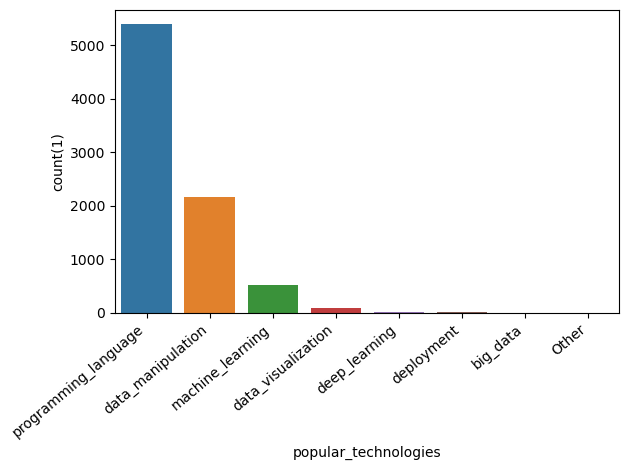

In [37]:
import seaborn as sns
ax = sns.barplot(data =c_f_p,x = 'popular_technologies', y= 'count(1)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [21]:
commits_x_content = DS_related_df.join(test_content_files,DS_related_df.repo_name ==  test_content_files.repo_name2,"inner").groupby('popular_technolgies').agg(count('*')).orderBy('count(1)', ascending = False).toPandas()

23/12/08 17:03:55 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 59.0 in stage 6.0 (TID 120) (hub-msca-bdp-dphub-students-backup-joonpark-w-1.c.msca-bdp-students.internal executor 3): TaskKilled (Stage cancelled)
23/12/08 17:03:55 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 44.0 in stage 5.0 (TID 116) (hub-msca-bdp-dphub-students-backup-joonpark-w-1.c.msca-bdp-students.internal executor 2): TaskKilled (Stage cancelled)
23/12/08 17:03:55 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 58.0 in stage 6.0 (TID 118) (hub-msca-bdp-dphub-students-backup-joonpark-w-1.c.msca-bdp-students.internal executor 3): TaskKilled (Stage cancelled)
23/12/08 17:03:55 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 45.0 in stage 5.0 (TID 117) (hub-msca-bdp-dphub-students-backup-joonpark-w-0.c.msca-bdp-students.internal executor 4): TaskKilled (Stage cancelled)
23/12/08 17:03:55 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 46.0 in stage 5.0 (TID 119) 

Py4JJavaError: An error occurred while calling o271.collectToPython.
: org.apache.spark.SparkException: Could not execute broadcast in 300 secs. You can increase the timeout for broadcasts via spark.sql.broadcastTimeout or disable broadcast join by setting spark.sql.autoBroadcastJoinThreshold to -1
	at org.apache.spark.sql.execution.adaptive.BroadcastQueryStageExec$$anon$1.run(QueryStageExec.scala:217)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ScheduledThreadPoolExecutor$ScheduledFutureTask.access$201(ScheduledThreadPoolExecutor.java:180)
	at java.util.concurrent.ScheduledThreadPoolExecutor$ScheduledFutureTask.run(ScheduledThreadPoolExecutor.java:293)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)


23/12/08 17:03:56 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 9.0 in stage 4.0 (TID 113) (hub-msca-bdp-dphub-students-backup-joonpark-w-0.c.msca-bdp-students.internal executor 5): TaskKilled (Stage cancelled)
23/12/08 17:03:57 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 8.0 in stage 4.0 (TID 112) (hub-msca-bdp-dphub-students-backup-joonpark-w-0.c.msca-bdp-students.internal executor 5): TaskKilled (Stage cancelled)
23/12/08 17:03:58 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 7.0 in stage 4.0 (TID 106) (hub-msca-bdp-dphub-students-backup-joonpark-w-1.c.msca-bdp-students.internal executor 2): TaskKilled (Stage cancelled)


In [ ]:
content_df.filter(content_df.content.isNotNull()).show(5)
file_df.filter(""" path rlike '.py|.md' """).show(5,False)

In [38]:
language_df = spark.read.parquet('gs://msca-bdp-data-open/final_project_git/languages')
popular_languages_df = language_df.select\
([col('repo_name'),explode(col('language.name')).alias('language_name')])

In [ ]:
ds_df_combined = DS_related_df.join(popular_languages_df,DS_related_df.repo_name ==  popular_languages_df.repo_name,"inner")

In [ ]:
ds_df_combined_first = ds_df_combined.filter('year = 2008 or year = 2009 or year = 2010 or year = 2011')

In [ ]:
ds_df_combined_second = ds_df_combined.filter('year = 2012 or year = 2013 or year = 2014 or year = 2015')

In [ ]:
ds_df_combined_third = ds_df_combined.filter('year = 2016 or year = 2017 or year = 2018 or year = 2019')

In [ ]:
ds_df_combined_fourth = ds_df_combined.filter('year = 2020 or year = 2021 or year = 2022 or year = 2023')

In [ ]:
ds_df_combined_first.groupby('language_name').agg(count('*')).orderBy('count(1)', ascending = False).show(5)

In [ ]:
ds_df_combined_second.groupby('language_name').agg(count('*')).orderBy('count(1)', ascending = False).show(5)

In [ ]:
ds_df_combined_third.groupby('language_name').agg(count('*')).orderBy('count(1)', ascending = False).show(5)


In [ ]:
ds_df_combined_fourth.groupby('language_name').agg(count('*')).orderBy('count(1)', ascending = False).show(5)

## Question 6

In [19]:
message_df = cleaned_commits_df.select\
([col('message')])

message_df = message_df.withColumn("message", (lower(col("message"))))

In [20]:
#message_df.groupby('message').agg(count("*")).orderBy('count(1)', ascending = False).show(100, False)

In [30]:
#From ChatGPT

word_mapping = {
    'update': 'update',
    "readme": 'update',
    'data.': 'update',
    'bug fix': 'bug fix',
    'bugfix': 'bug fix',
    'fix': 'bug fix',
    'repair': 'bug fix',
    'commit': 'commit',
    'push': 'branching',
    'merge': 'branching',
    'development': 'technological developement',
    'pull': 'branching'
}


test_message_df = message_df.withColumn("Common Messages", 
                   when(col("message").contains('update'), word_mapping['update'])
                   .when(col("message").contains('bugfix'), word_mapping['bug fix'])
                   .when(col("message").contains('fix'), word_mapping['bug fix'])
                   .when(col("message").contains('push'), word_mapping['push'])
                    .when(col("message").contains('commit'), word_mapping['commit'])
                   .when(col("message").contains('fix'), word_mapping['bug fix'])
                   .when(col("message").contains('merge'), word_mapping['merge'])
                    .when(col("message").contains('pull'), word_mapping['pull'])
                   .when(col("message").contains('development'), word_mapping['development'])
                   .when(col("message").contains('technology'), word_mapping['development'])
                    .when(col("message").contains('innovation'), word_mapping['development'])
                   .when(col("message").contains('artificial intelligence'), word_mapping['development'])
                   .when(col("message").contains('machine learning'), word_mapping['development'])
                   .otherwise('Other')
                 )


# Use the 'withColumn' function and 'when' function to create a new column
# for word, mapping in word_mapping.items():
#     test_message_df = message_df.withColumn("broken_up", when(col("message").contains(word), mapping).otherwise(col('broken_up')))
    


In [31]:
test_message_df.groupby('Common Messages').agg(count("*")).orderBy('count(1)', ascending = False).show(10, False)

+--------------------------+---------+
|Common Messages           |count(1) |
+--------------------------+---------+
|Other                     |150805707|
|bug fix                   |36225403 |
|update                    |35037166 |
|branching                 |21286355 |
|commit                    |8392974  |
|technological developement|492467   |
+--------------------------+---------+



## Preliminary Results: Mostly for updates

## Question 7:

In [ ]:
cleaned_commits_df = commits_df.select\
([col('author.time_sec').alias('author_time_sec'), col('repo_name'), col('message'), col('subject'),col('committer.name')])
cleaned_commits_df = cleaned_commits_df.withColumn("time_timestamp", (f.col("author_time_sec")).cast("timestamp"))
cleaned_commits_df = cleaned_commits_df.withColumn('date_only', to_date(col('time_timestamp')))
cleaned_commits_df = cleaned_commits_df.withColumn('year', year(col('date_only')))
cleaned_commits_df = cleaned_commits_df.filter('year > 2007').filter('year < 2023')


cleaned_commits_df = cleaned_commits_df.filter('author_time_sec != 1495574320').filter('author_time_sec != 1508791747').filter('author_time_sec != 1474329600').filter('author_time_sec != 1425427200')

In [ ]:
committing = cleaned_commits_df.groupby('name').agg(count("*")).orderBy('count(1)', ascending = False).toPandas()

In [ ]:
committing = committing[~committing['name'].isin(['root', 'time'])]

In [ ]:
shortened_name = committing.head(10)

In [ ]:
shortened_name.plot.bar(x='name', y='count(1)', rot=80)

## Question 8

In [ ]:
import pyspark
import time

In [ ]:
sc = spark.sparkContext
print('Original spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))

# Stop existing Spark environment
sc.stop()

# Waiting for the environment to stop
sleep_time = 30
print(f'Waiting for {sleep_time} seconds for the enviroment to stop...')
time.sleep(sleep_time)

# Applying new configuration and restarting Spark
conf = pyspark.SparkConf().setAll([
                                   ('spark.driver.maxResultSize', '16g'), \
                                       ('spark.driver.memory','8g'),  \
                                   ('spark.num.executors', '32'),  \
                                   ('spark.cores.max','24'),  \
                                   ('spark.executor.memory', '10G'),  \
                                   ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),  \
                                   ('spark.kryoserializer.buffer.max', '256m'),  \
                                   ('spark.driver.cores', '3'),  \
                                  ])
sc = pyspark.SparkContext(conf=conf)

print('New spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))

# Starting  Spark session with configs applied
spark = SparkSession(sc).builder.getOrCreate()


In [ ]:
# text_analysis_df = commits_df.select\
# ([col('message'),explode(col('repo_name')).alias('repo_name')])

text_analysis_df = cleaned_commits_df.select\
([explode(col('repo_name')).alias('repo_name2'), col('subject')])

In [ ]:
language_df = spark.read.parquet('gs://msca-bdp-data-open/final_project_git/languages')
popular_languages_df = language_df.select\
([col('repo_name'),explode(col('language.name')).alias('language_name')]).filter("language_name in ('JavaScript','CSS','HTML','Shell','Python')")


## Maybe when combining use select the comulmns that are absolutely necessary

In [ ]:
text_analysis_df = text_analysis_df.sample(fraction = 0.000005, seed = 123) #Roughly 40k rows

#text_analysis_df = text_analysis_df.limit(10000) #Roughly 40k rows
text_analysis_df = text_analysis_df.filter(length(text_analysis_df.subject)>=1) 
#Limit instead of taking a random sample because the data is ordered

In [ ]:
# rows = text_analysis_combined.count()
# print(f"DataFrame Rows count : {rows}")

In [ ]:
import pandas as pd
import numpy as np
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 10)
pd.reset_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', 500)


warnings.filterwarnings(action='ignore')

In [ ]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.ml.feature import StopWordsRemover # PySpark currently does not directly support automatic stop word lists for languages other than English
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import pyspark.sql.functions as F

In [ ]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.repl.eagerEval.maxCharsPerCell", 200)

In [ ]:
df_text = text_analysis_df.select(["repo_name2","subject"]).withColumnRenamed('subject', 'text')

In [ ]:
# Add an 'id' column to df: the IDs are not necessarily consecutive but are guaranteed to be unique across the entire DataFrame.
df_text = df_text.withColumn("id", monotonically_increasing_id())

# Split text into words
df_text = df_text.withColumn("text", split(col('text'), "\n\n")[0])
df_text = df_text.withColumn("words", split(col("text"), " "))


# Remove punctuation and split into words

df_text = df_text.withColumn("clean_text", F.regexp_replace(col("text"), r'\bam\s+\S+:\s*', ''))
emoji_pattern = r"["u"\U0001F600-\U0001F64F"u"\U0001F300-\U0001F5FF"u"\U0001F680-\U0001F6FF"u"\U0001F1E0-\U0001F1FF"u"\U00002500-\U00002BEF"u"\U00002702-\U000027B0"u"\U000024C2-\U0001F251"u"\U0001f926-\U0001f937"u"\U00010000-\U0010ffff"u"\u2640-\u2642" u"\u2600-\u2B55"u"\u200d"u"\u23cf"u"\u23e9"u"\u231a"u"\ufe0f"u"\u3030""]"
df_text = df_text.withColumn("clean_text", F.regexp_replace(col("clean_text"), emoji_pattern, ''))
latin_pattern = r'[^\x00-\x7F]'
df_text = df_text.withColumn("clean_text", regexp_replace(col("clean_text"), latin_pattern, ' '))

slash_pattern = r'\S*\/\S*'
df_text = df_text.withColumn("clean_text", regexp_replace(col("clean_text"), slash_pattern, ' '))

colon_pattern = r'\S*:\S*'
df_text = df_text.withColumn("clean_text", regexp_replace(col("clean_text"), colon_pattern, ''))

dash_pattern = r'\S*-\S*'
df_text = df_text.withColumn("clean_text", regexp_replace(col("clean_text"), dash_pattern, ''))

punctuation_pattern = r'\b\w*[\p{P}\p{S}]+\w*\b'
df_text = df_text.withColumn("clean_text", regexp_replace(col("clean_text"), punctuation_pattern, ''))

df_text = df_text.withColumn("clean_text", F.regexp_replace(col("clean_text"), r'https\S*', ''))
df_text = df_text.withColumn("clean_text", F.regexp_replace(col("clean_text"), r'https\S*', ''))
df_text = df_text.withColumn("clean_text", F.regexp_replace(col("clean_text"), r'\([^)]*\)', ''))
df_text = df_text.withColumn("clean_text", F.regexp_replace(col("clean_text"), r'\[[^\]]*\]', ''))
df_text = df_text.withColumn("clean_text", F.regexp_replace(F.col("clean_text"), "[^a-zA-Z0-9\\s]", ""))
df_text = df_text.withColumn("clean_text", F.regexp_replace(F.col("clean_text"), "[\p{P}\p{C}]", ""))



df_text = df_text.withColumn("words", split(F.col("clean_text"), " "))


# Filter out tokens that are less than 3 characters
df_text = df_text.withColumn("clean_words", F.expr("filter(words, word -> length(word) >= 3)"))

# Remove stopwords
remover = StopWordsRemover(inputCol="clean_words", outputCol="filtered_words")
df_text = remover.transform(df_text)
df_text = df_text.filter(size(col('filtered_words')) >= 3)
df_text = df_text.filter(df_text.filtered_words.isNotNull())
df_text = df_text.filter(df_text.text.isNotNull())
# display(df_text.select('id', 
#                        'text', 
#                        'clean_text', 
#                        'words', 
#                        'clean_words',
#                        'filtered_words').limit(30).toPandas())

# Keep only the variables we need
df_text = df_text.select('id','repo_name2','text','filtered_words')

In [ ]:
vectorize = CountVectorizer(inputCol="filtered_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_text).transform(df_text)
#display(df_vectorize.limit(5).toPandas())

In [ ]:

from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT, SparseVector, DenseVector

def ensure_non_zero_vector(v):
    if v is None:
        return Vectors.dense([0.1])  # Replace with an appropriate non-zero vector
    elif isinstance(v, SparseVector) and v.numNonzeros() == 0:
        # For sparse vector with all zeros, add a non-zero entry
        return Vectors.dense([0.1] + [0.0] * (len(v) - 1))
    elif isinstance(v, DenseVector) and all(x == 0 for x in v.toArray()):
        # For dense vector with all zeros, add a non-zero entry
        return Vectors.dense([0.1] + [0.0] * (len(v) - 1))
    else:
        return v  # Return the vector as-is if it's not all zeros

ensure_non_zero_vector_udf = udf(ensure_non_zero_vector, VectorUDT())

df_with_non_zero_vectors = df_vectorize.withColumn("lsh_features", ensure_non_zero_vector_udf("features"))

In [ ]:
mh = MinHashLSH(inputCol="lsh_features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_with_non_zero_vectors)

df_hashed_text = mh.fit(df_with_non_zero_vectors).transform(df_with_non_zero_vectors)

display(df_hashed_text.limit(5).toPandas())

In [ ]:
jaccard_distance = 0.3
df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.repo_name2").alias("repo_name"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [ ]:
df_dups_30 = df_dups_text
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

In [ ]:
dups_df_30 = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df_30.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()/2),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

In [ ]:
duplications = df_dups_text.select('id_A', col('repo_name').alias('repo_name2')).distinct()

In [ ]:
language_df = spark.read.parquet('gs://msca-bdp-data-open/final_project_git/languages')
popular_languages_df = language_df.select\
([col('repo_name'),explode(col('language.name')).alias('language_name')])

language_x_dupes = popular_languages_df.join(duplications,popular_languages_df.repo_name ==  duplications.repo_name2,"inner")




In [ ]:
language = language_x_dupes.select('language_name')

In [ ]:
language_x_dupes_pd = language.groupby('language_name').agg(count('*')).orderBy('count(1)',ascending = False).toPandas()

In [ ]:
shortened = language_x_dupes_pd.head(10)

In [ ]:
ax = shortened.plot.bar(x='language_name', y='count(1)', rot=45)

In [ ]:


programming_list = ['JavaScript','CSS','HTML','Shell','Python']

filtered_df = language_x_dupes_pd[language_x_dupes_pd['language_name'].isin(programming_list)]
filtered_df.plot.bar(x='language_name', y='count(1)', rot=45)